#Predicting Sunspots

##Predicting Sunspots with Neural Networks (DNN only)

Here, we will train on the Sunspots dataset: a monthly record of sunspot numbers from January 1749 to July 2018. We will first build a deep neural network here composed of dense layers. This will act as your baseline so we can compare it to the next section where we will use a more complex architecture.

###Imports


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

###Utilities



In [ ]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

###Download and Preview the Dataset
We can now download the dataset and inspect the contents.


In [ ]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv


--2023-02-02 04:58:50--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.13.128, 172.217.193.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.13.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2023-02-02 04:58:51 (116 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



we see that there are only three columns in the dataset:

* untitled column containing the month number
* Date which has the format YYYY-MM-DD
* Mean Total Sunspot Number


In [ ]:
# Preview the dataset
!head Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


Here, we only need the month number and the mean total sunspot number. We will load those into memory and convert it to arrays that represents a time series.


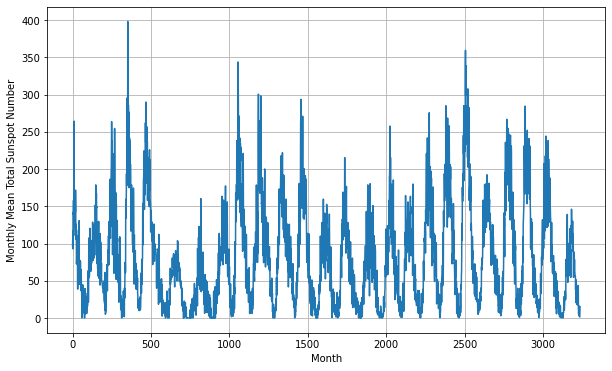

In [ ]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

###Split the Dataset
Next, we will split the dataset into training and validation sets. There are 3235 points in the dataset and we will use the first 3000 for training.



In [ ]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

###Prepare Features and Labels

We can then prepare the dataset windows. The window size is set to 30 points (equal to 2.5 years) but will change later on if we want to experiment.



In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset


In [ ]:
# Parameters
window_size = 30
batch_size = 64
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

###Build the Model
The model will be 3-layer dense network as shown below.



In [ ]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1984      
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,041
Trainable params: 3,041
Non-trainable params: 0
_________________________________________________________________


###Tune the Learning Rate
we can pick a learning rate by running the same learning rate scheduler.



In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
47/47 [==============================] - 1s 7ms/step - loss: 54.3539 - lr: 1.0000e-08
Epoch 2/100
47/47 [==============================] - 0s 7ms/step - loss: 53.8029 - lr: 1.1220e-08
Epoch 3/100
47/47 [==============================] - 0s 7ms/step - loss: 53.1731 - lr: 1.2589e-08
Epoch 4/100
47/47 [==============================] - 0s 8ms/step - loss: 52.4930 - lr: 1.4125e-08
Epoch 5/100
47/47 [==============================] - 0s 6ms/step - loss: 51.7685 - lr: 1.5849e-08
Epoch 6/100
47/47 [==============================] - 0s 7ms/step - loss: 50.9911 - lr: 1.7783e-08
Epoch 7/100
47/47 [==============================] - 0s 7ms/step - loss: 50.1697 - lr: 1.9953e-08
Epoch 8/100
47/47 [==============================] - 0s 8ms/step - loss: 49.2770 - lr: 2.2387e-08
Epoch 9/100
47/47 [==============================] - 0s 7ms/step - loss: 48.3514 - lr: 2.5119e-08
Epoch 10/100
47/47 [==============================] - 0s 8ms/step - loss: 47.3822 - lr: 2.8184e-08
Epoch 11/100
47/47 

(1e-08, 0.001, 0.0, 100.0)

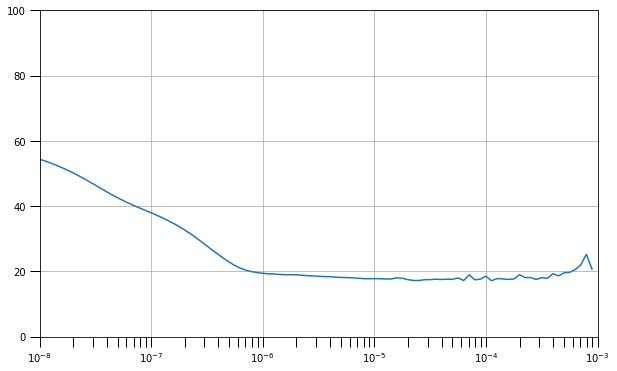

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

###Train the Model
Once we've picked a learning rate, we can rebuild the model and start training.


In [ ]:

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1)
])


In [ ]:
# Set the learning rate
learning_rate = 1e-4

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=350)

Epoch 1/350
47/47 [==============================] - 1s 8ms/step - loss: 35.0306 - mae: 35.5246
Epoch 2/350
47/47 [==============================] - 0s 8ms/step - loss: 19.5548 - mae: 20.0487
Epoch 3/350
47/47 [==============================] - 0s 8ms/step - loss: 18.8723 - mae: 19.3655
Epoch 4/350
47/47 [==============================] - 0s 7ms/step - loss: 18.1833 - mae: 18.6757
Epoch 5/350
47/47 [==============================] - 0s 8ms/step - loss: 17.8392 - mae: 18.3320
Epoch 6/350
47/47 [==============================] - 0s 7ms/step - loss: 18.1533 - mae: 18.6459
Epoch 7/350
47/47 [==============================] - 0s 8ms/step - loss: 17.5314 - mae: 18.0215
Epoch 8/350
47/47 [==============================] - 0s 8ms/step - loss: 17.4858 - mae: 17.9782
Epoch 9/350
47/47 [==============================] - 0s 7ms/step - loss: 17.5656 - mae: 18.0577
Epoch 10/350
47/47 [==============================] - 0s 7ms/step - loss: 17.4552 - mae: 17.9469
Epoch 11/350
47/47 [===================

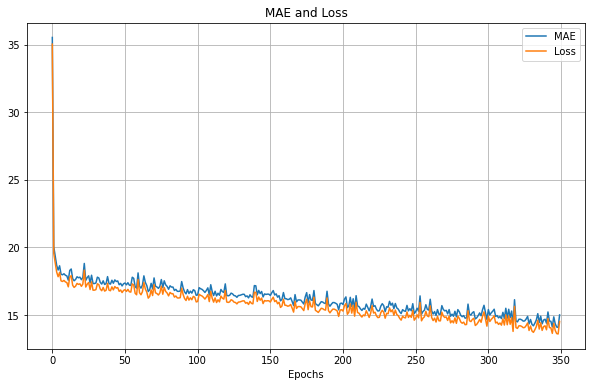

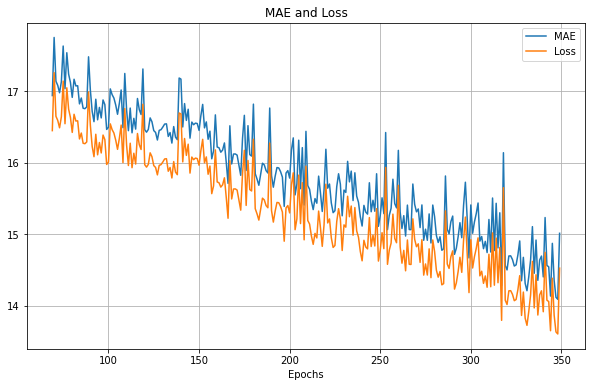

In [ ]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

###Model Prediction

Now see if the model generates good results



In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast


4/4 [==============================] - 0s 18ms/step


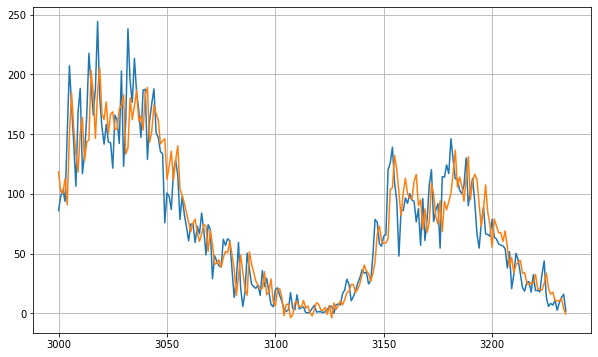

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))


In [ ]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

16.042189


##Predicting Sunspots with Neural Networks(Conv and LSTM)

Here, we will use a combination of all these types of networks: the data windows will pass through a convolution, followed by stacked LSTMs, followed by stacked dense layers. See if this improves results or we can just opt for simpler models.

In [ ]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


###Build the Model



In [ ]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 30)                1950      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                

###Tune the Learning Rate
We will want to pick an optimal learning rate.



Epoch 1/100
93/93 [==============================] - 9s 44ms/step - loss: 99.3822 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 4s 43ms/step - loss: 59.7802 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 4s 44ms/step - loss: 48.6756 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 4s 44ms/step - loss: 42.6660 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 6s 64ms/step - loss: 38.9696 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 4s 44ms/step - loss: 36.7023 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 4s 43ms/step - loss: 35.2275 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 4s 44ms/step - loss: 34.2066 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 6s 63ms/step - loss: 33.4155 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 6s 64ms/step - loss: 32.6826 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 100.0)

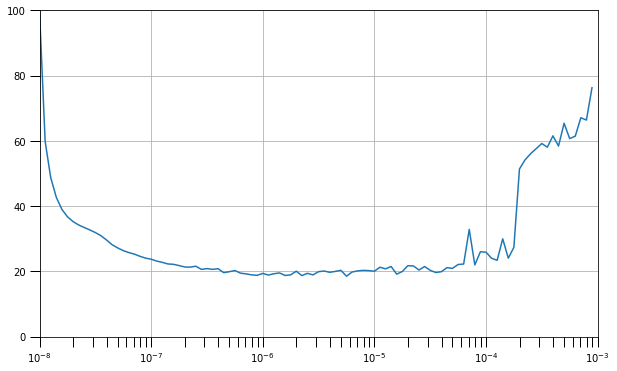

In [ ]:
# Get initial weights
init_weights = model.get_weights()
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])


###Train the Model
Now we can proceed to reset and train the model. 



In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)
# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


In [ ]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 8s 44ms/step - loss: 37.7380 - mae: 38.2341
Epoch 2/100
93/93 [==============================] - 4s 44ms/step - loss: 25.7586 - mae: 26.2534
Epoch 3/100
93/93 [==============================] - 4s 44ms/step - loss: 23.2280 - mae: 23.7229
Epoch 4/100
93/93 [==============================] - 4s 44ms/step - loss: 21.6534 - mae: 22.1470
Epoch 5/100
93/93 [==============================] - 4s 44ms/step - loss: 20.4376 - mae: 20.9323
Epoch 6/100
93/93 [==============================] - 4s 43ms/step - loss: 20.2321 - mae: 20.7249
Epoch 7/100
93/93 [==============================] - 4s 42ms/step - loss: 19.1316 - mae: 19.6258
Epoch 8/100
93/93 [==============================] - 4s 43ms/step - loss: 19.1361 - mae: 19.6294
Epoch 9/100
93/93 [==============================] - 4s 42ms/step - loss: 19.5509 - mae: 20.0442
Epoch 10/100
93/93 [==============================] - 4s 42ms/step - loss: 18.8169 - mae: 19.3098
Epoch 11/100
93/93 [=========

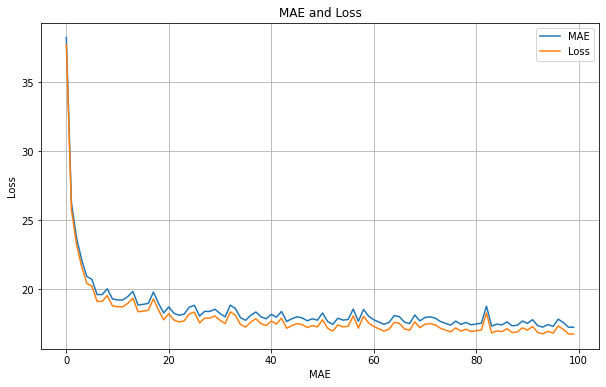

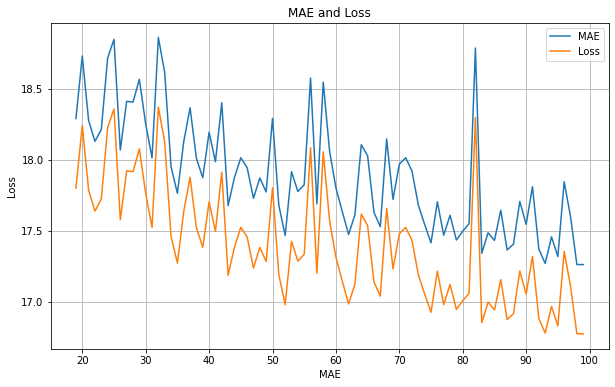

In [ ]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )


###Model Prediction

As before, we can get the predictions for the validation set time range and compute the metrics.



In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast


8/8 [==============================] - 1s 19ms/step


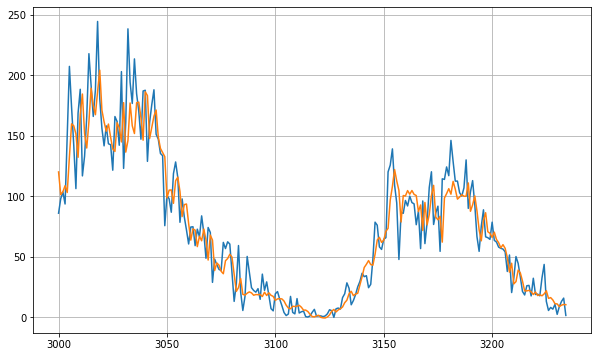

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))


In [ ]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.176897
